資料集來源：https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/stock_data.csv', encoding='utf-8')

In [ ]:
data

,Text,Sentiment
0,kickers on my watchlist xide tit soq pnk cpw b...,1
1,user aap movie return for the feageed indicat...,1
2,user id be afraid to short amzn they are look...,1
3,mnta over,1
4,oi over,1
...,...,...
5786,industry body cii said discoms are likely to s...,-1
5787,gold prices slip below rs as investors book p...,-1
5788,workers at bajaj auto have agreed to a wage c...,1
5789,sharemarket live sensex off days high up poin...,1


In [ ]:
data['Sentiment'].value_counts()

Sentiment
 1    3685
-1    2106
Name: count, dtype: int64

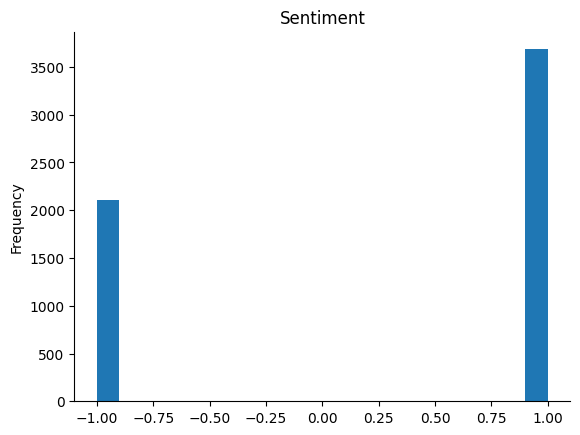

In [ ]:
# @title Sentiment

from matplotlib import pyplot as plt
data['Sentiment'].plot(kind='hist', bins=20, title='Sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
data.isnull().sum()
#資料集無殘缺

Text         0
Sentiment    0
dtype: int64

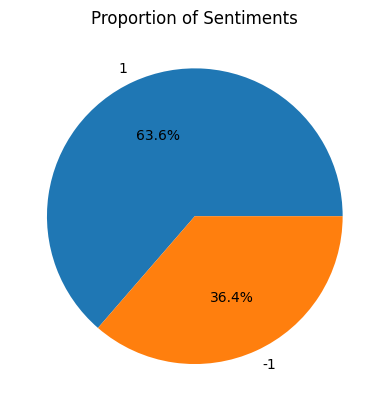

In [ ]:
# @title Proportion of Sentiments

import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = data['Sentiment'].value_counts()

# Create a pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
_ = plt.title('Proportion of Sentiments')

可發現資料即是比較不平衡的

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import random

# 確保下載nltk資料
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# 資料清理函數
def clean_text(text):
    text = text.lower()  # 轉小寫
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # 移除URL
    text = re.sub(r'\@w+|\#','', text)  # 移除@和#
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # 移除標點符號
    text = re.sub(r'\d+', '', text)  # 移除數字
    text = text.strip()  # 去除首尾空格
    return text


# 同義詞替換增強函數
def synonym_replacement(sentence, n=1):
    words = sentence.split()
    new_words = words.copy()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words = [synonym if word == word_to_replace else word for word in new_words]
    return ' '.join(new_words)

# 打亂句子結構增強函數
def shuffle_sentence(sentence):
    words = sentence.split()
    random.shuffle(words)
    return ' '.join(words)

# 綜合增強函數
def augment_text(sentence):
    sentence = synonym_replacement(sentence, n=1)
    sentence = shuffle_sentence(sentence)
    return sentence

# 清理文本
data['Text'] = data['Text'].apply(clean_text)

# 分離文字和情緒標籤
texts = data['Text']
emotions = data['Sentiment']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data

,Text,Sentiment
0,kickers on my watchlist xide tit soq pnk cpw b...,1
1,user aap movie return for the feageed indicat...,1
2,user id be afraid to short amzn they are look...,1
3,mnta over,1
4,oi over,1
...,...,...
5786,industry body cii said discoms are likely to s...,-1
5787,gold prices slip below rs as investors book p...,-1
5788,workers at bajaj auto have agreed to a wage c...,1
5789,sharemarket live sensex off days high up poin...,1


In [ ]:
# 綜合增強數據
augmented_texts = []
for text, emotion in zip(texts, emotions):
    if emotion == -1:  # 只對負情緒進行增強
        augmented_text = augment_text(text)
        augmented_texts.append({'Text': augmented_text, 'Sentiment': emotion})

# 將增強後的數據合併到原始數據集
augmented_data = pd.concat([data, pd.DataFrame(augmented_texts)], ignore_index=True)

# 確認合併後的數據集
print("Augmented data set:")
print(augmented_data)

Augmented data set:
                                                   Text  Sentiment
0     kickers on my watchlist xide tit soq pnk cpw b...          1
1     user aap movie  return for the feageed indicat...          1
2     user id be afraid to short amzn  they are look...          1
3                                             mnta over          1
4                                              oi  over          1
...                                                 ...        ...
7892  economic coronaviruspandemic more the the is d...         -1
7893  that in st economy epidemic into forced was as...         -1
7894  defensive sachs beat slump tells virus go larg...         -1
7895  discoms to around net loss crore of are body r...         -1
7896  recession below fears amid investors slip as R...         -1

[7897 rows x 2 columns]


In [ ]:
# 确认情绪标签的唯一值
emotions = augmented_data['Sentiment']
print("Unique values in emotions:", emotions.unique())

# 将情绪标签进行编码
label_encoder = LabelEncoder()
emotions_encoded = label_encoder.fit_transform(emotions)

# 检查编码后的唯一值
print("Unique values in emotions_encoded:", np.unique(emotions_encoded))

# 手动检查和转换情绪标签为0和1
emotions_encoded = np.where(augmented_data['Sentiment'] == -1, 0, 1)
print("After manual transformation, unique values in emotions_encoded:", np.unique(emotions_encoded))

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(augmented_data['Text'], emotions_encoded, test_size=0.2, random_state=42)

# 确保训练和测试集的标签唯一值
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

print("Data augmentation completed.")

Unique values in emotions: [ 1 -1]
Unique values in emotions_encoded: [0 1]
After manual transformation, unique values in emotions_encoded: [0 1]
Unique values in y_train: [0 1]
Unique values in y_test: [0 1]
Data augmentation completed.


In [ ]:
# prompt: 檢查數據增強後的資料集大小 分別是正面和負面

augmented_data['Sentiment'].value_counts()


Sentiment
-1    4212
 1    3685
Name: count, dtype: int64

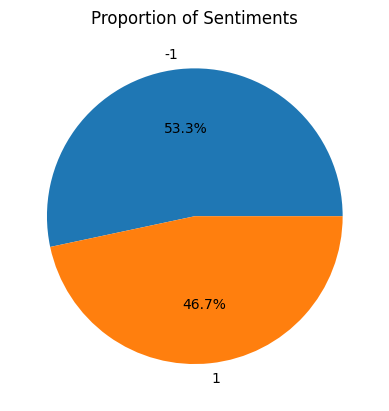

In [ ]:
# @title Proportion of Sentiments

import matplotlib.pyplot as plt

# Count the occurrences of each sentiment
sentiment_counts = augmented_data['Sentiment'].value_counts()

# Create a pie chart
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
_ = plt.title('Proportion of Sentiments')

### **word2vec**

In [ ]:
from gensim.models import Word2Vec
import numpy as np

# 將文本標記化
tokenized_texts = [word_tokenize(text) for text in X_train]

# 訓練Word2Vec模型
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=300, window=10, min_count=1, workers=4)

# 生成詞向量的函數
def get_w2v_vector(text):
    tokens = word_tokenize(text)
    vector = np.mean([w2v_model.wv[token] for token in tokens if token in w2v_model.wv], axis=0)
    if isinstance(vector, np.ndarray):
        return vector
    else:
        return np.zeros(300)

# 將訓練集和測試集轉換為向量
X_train_w2v = np.array([get_w2v_vector(text) for text in X_train])
X_test_w2v = np.array([get_w2v_vector(text) for text in X_test])

# 如果有缺失值（全是未出現詞），則補零向量
X_train_w2v = np.nan_to_num(X_train_w2v)
X_test_w2v = np.nan_to_num(X_test_w2v)

In [ ]:
X_train_w2v

array([[ 0.05409548,  0.35170597,  0.02849689, ..., -0.15267354,
         0.21513155, -0.06981268],
       [ 0.03072447,  0.22819868,  0.04118833, ..., -0.14038286,
         0.17107585, -0.05239639],
       [ 0.05599502,  0.38509396,  0.06511904, ..., -0.23589393,
         0.28587756, -0.09014736],
       ...,
       [ 0.03667165,  0.25665265,  0.04617003, ..., -0.15994772,
         0.19195423, -0.05939126],
       [ 0.05166622,  0.34984416,  0.05608506, ..., -0.20489849,
         0.254414  , -0.07955785],
       [ 0.00204742,  0.00801015,  0.00157459, ..., -0.00377869,
         0.00739131, -0.00156006]], dtype=float32)

### **bert**

In [ ]:
!pip install transformers
!pip install scikit-learn
!pip install tqdm

import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# 使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
# 加載BERT模型和標記器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)  # 將模型移動到 GPU

# 設置為評估模式
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# 生成BERT詞向量的函數
def get_bert_vector(texts, batch_size=16):
    all_cls_embeddings = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts.tolist(), return_tensors='pt', truncation=True, padding=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}  # 移動到GPU

        with torch.no_grad():
            outputs = model(**inputs)

        cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # 移到CPU並轉換為numpy
        all_cls_embeddings.extend(cls_embeddings)

    return np.array(all_cls_embeddings)

# 將訓練集和測試集轉換為向量
X_train_bert = get_bert_vector(X_train)
X_test_bert = get_bert_vector(X_test)


100%|██████████| 99/99 [02:31<00:00,  1.53s/it]


In [ ]:
X_train_bert

array([[-0.412744  , -0.06327974,  0.31435785, ..., -0.532389  ,
        -0.0357389 ,  0.09567103],
       [-0.2774287 ,  0.04613997,  0.0443465 , ..., -0.42565525,
         0.1341548 ,  0.5799537 ],
       [-0.23087057,  0.04627104,  0.28377265, ..., -0.16905557,
         0.28360623,  0.24268745],
       ...,
       [ 0.08582894, -0.01247747,  0.34396395, ..., -0.4801729 ,
         0.2709672 ,  0.27456674],
       [-0.17246386,  0.04487026, -0.03098492, ..., -0.57692903,
        -0.10229421,  0.41448888],
       [-0.10032072,  0.22234513, -0.0270679 , ..., -0.3075844 ,
         0.15486053,  0.25975654]], dtype=float32)

### **使用LogisticRegression進行分類**

Classification Report (Word2Vec + LogisticRegression):
              precision    recall  f1-score   support

    negative       0.51      1.00      0.68       801
    positive       0.80      0.02      0.04       779

    accuracy                           0.51      1580
   macro avg       0.66      0.51      0.36      1580
weighted avg       0.65      0.51      0.36      1580

Confusion Matrix (Word2Vec + LogisticRegression):


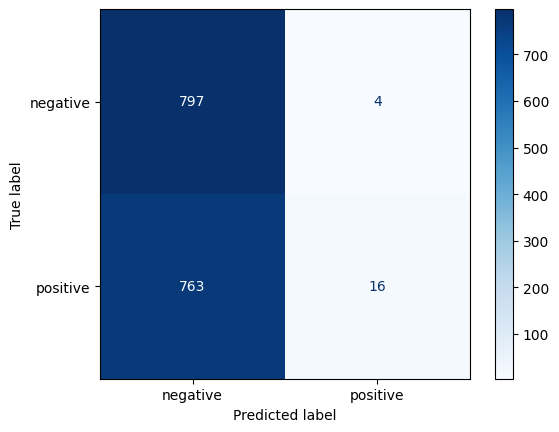

Classification Report (BERT + LogisticRegression):
              precision    recall  f1-score   support

    negative       0.76      0.77      0.76       801
    positive       0.76      0.75      0.75       779

    accuracy                           0.76      1580
   macro avg       0.76      0.76      0.76      1580
weighted avg       0.76      0.76      0.76      1580

Confusion Matrix (BERT + LogisticRegression):


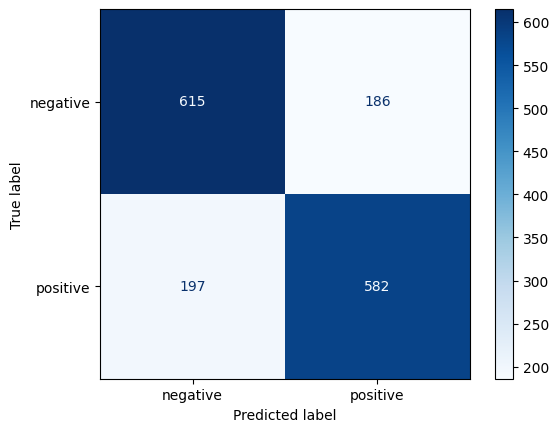

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 訓練Logistic Regression模型 (Word2Vec)
clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_train_w2v, y_train)
y_pred_w2v_lr = clf_w2v.predict(X_test_w2v)

# 評估Word2Vec模型
target_names = ['negative', 'positive']  # 根據你的情緒標籤定義
print("Classification Report (Word2Vec + LogisticRegression):")
print(classification_report(y_test, y_pred_w2v_lr, target_names=target_names))
conf_matrix_w2v_lr = confusion_matrix(y_test, y_pred_w2v_lr)
print("Confusion Matrix (Word2Vec + LogisticRegression):")
disp_w2v_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v_lr, display_labels=target_names)
disp_w2v_lr.plot(cmap=plt.cm.Blues)
plt.show()

# 訓練Logistic Regression模型 (BERT)
clf_bert = LogisticRegression(max_iter=1000)
clf_bert.fit(X_train_bert, y_train)
y_pred_bert_lr = clf_bert.predict(X_test_bert)

# 評估BERT模型
print("Classification Report (BERT + LogisticRegression):")
print(classification_report(y_test, y_pred_bert_lr, target_names=target_names))
conf_matrix_bert_lr = confusion_matrix(y_test, y_pred_bert_lr)
print("Confusion Matrix (BERT + LogisticRegression):")
disp_bert_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_lr, display_labels=target_names)
disp_bert_lr.plot(cmap=plt.cm.Blues)
plt.show()


### **使用GridSearch進行超參數調整**

In [ ]:
from sklearn.model_selection import GridSearchCV

# 設置參數網格 (Word2Vec)
param_grid_w2v = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# 進行Grid Search (Word2Vec)
grid_w2v = GridSearchCV(LogisticRegression(), param_grid_w2v, refit=True, verbose=2, cv=3)
grid_w2v.fit(X_train_w2v, y_train)
print("Best parameters found (Word2Vec): ", grid_w2v.best_params_)

# 設置參數網格 (BERT)
param_grid_bert = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['lbfgs', 'liblinear']
}

# 進行Grid Search (BERT)
grid_bert = GridSearchCV(LogisticRegression(), param_grid_bert, refit=True, verbose=2, cv=3)
grid_bert.fit(X_train_bert, y_train)
print("Best parameters found (BERT): ", grid_bert.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.2s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.3s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.4s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END ..................C=1, penalty=l2, solve

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time= 8.8min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time= 8.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ................C=100, penalty=l1, solver=liblinear; total time= 7.9min
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.2s


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
# 使用最佳參數進行預測 (Word2Vec)
y_pred_w2v = grid_w2v.predict(X_test_w2v)

# 手動定義 target_names
target_names = list(map(str, label_encoder.classes_))

# 評估Word2Vec模型
print("Classification Report (Word2Vec):")
print(classification_report(y_test, y_pred_w2v, target_names=target_names))

# 繪製混淆矩陣
conf_matrix_w2v = confusion_matrix(y_test, y_pred_w2v)
disp_w2v = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v, display_labels=target_names)
disp_w2v.plot()
plt.title('Confusion Matrix (Word2Vec)')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# 使用最佳模型進行預測
y_pred_bert = grid_bert.predict(X_test_bert)

# 將y_test反編碼為原始標籤
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred_bert)

# 確認唯一值
print("Unique values in y_test_original:", np.unique(y_test_original))
print("Unique values in y_pred_original:", np.unique(y_pred_original))

# 檢查原始標籤類型，並手動定義target_names
target_names = list(map(str, label_encoder.classes_))

# 生成分類報告
print("Classification Report:")
print(classification_report(y_test, y_pred_bert, target_names=target_names))

# 繪製混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred_bert)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=target_names)
disp.plot()
plt.show()

### **使用隨機森林**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 訓練RandomForest模型 (Word2Vec)
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
rf_w2v.fit(X_train_w2v, y_train)

# 预测
y_pred_w2v_rf = rf_w2v.predict(X_test_w2v)

# 訓練RandomForest模型 (BERT)
rf_bert = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bert.fit(X_train_bert, y_train)

# 预测
y_pred_bert_rf = rf_bert.predict(X_test_bert)

Classification Report (Word2Vec + Random Forest):
              precision    recall  f1-score   support

    negative       0.69      0.79      0.74       801
    positive       0.75      0.63      0.68       779

    accuracy                           0.71      1580
   macro avg       0.72      0.71      0.71      1580
weighted avg       0.72      0.71      0.71      1580

Confusion Matrix (Word2Vec + Random Forest):


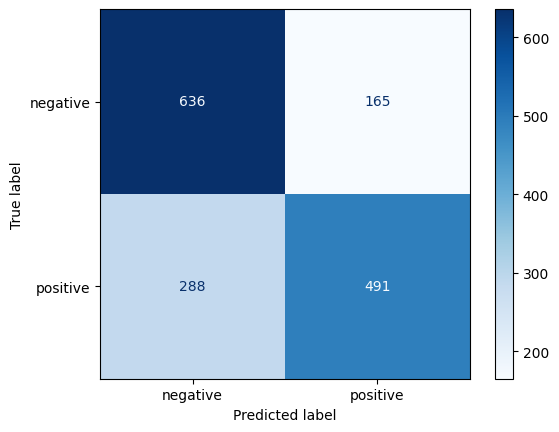

Classification Report (BERT + Random Forest):
              precision    recall  f1-score   support

    negative       0.69      0.80      0.74       801
    positive       0.75      0.64      0.69       779

    accuracy                           0.72      1580
   macro avg       0.72      0.72      0.71      1580
weighted avg       0.72      0.72      0.72      1580

Confusion Matrix (BERT + Random Forest):


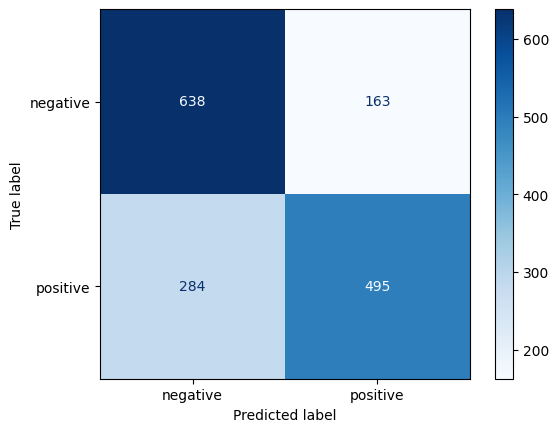

In [ ]:
# 评估
print("Classification Report (Word2Vec + Random Forest):")
print(classification_report(y_test, y_pred_w2v_rf,target_names=target_names))
conf_matrix_w2v_rf = confusion_matrix(y_test, y_pred_w2v_rf)
print("Confusion Matrix (Word2Vec + Random Forest):")
disp_w2v_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v_rf, display_labels=target_names)
disp_w2v_rf.plot(cmap=plt.cm.Blues)
plt.show()

# 评估
print("Classification Report (BERT + Random Forest):")
print(classification_report(y_test, y_pred_bert_rf,target_names=target_names))
conf_matrix_bert_rf = confusion_matrix(y_test, y_pred_bert_rf)
print("Confusion Matrix (BERT + Random Forest):")

disp_bert_rf = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_rf, display_labels=target_names)
disp_bert_rf.plot(cmap=plt.cm.Blues)
plt.show()

### **使用SVM**

In [ ]:
from sklearn.svm import SVC

In [ ]:
# 訓練SVM模型 (Word2Vec)
clf_svm_w2v = SVC(kernel='linear', C=1.0, random_state=42)
clf_svm_w2v.fit(X_train_w2v, y_train)

# 在验证集上做出预测
y_pred_svm_w2v = clf_svm_w2v.predict(X_test_w2v)

# 訓練SVM模型 (BERT)
clf_svm_bert = SVC(kernel='linear', C=1.0, random_state=42)
clf_svm_bert.fit(X_train_bert, y_train)

# 在验证集上做出预测
y_pred_svm_bert = clf_svm_bert.predict(X_test_bert)

Classification Report (Word2Vec + SVM):
              precision    recall  f1-score   support

    negative       0.51      1.00      0.67       801
    positive       0.00      0.00      0.00       779

    accuracy                           0.51      1580
   macro avg       0.25      0.50      0.34      1580
weighted avg       0.26      0.51      0.34      1580

Confusion Matrix (Word2Vec + SVM):


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


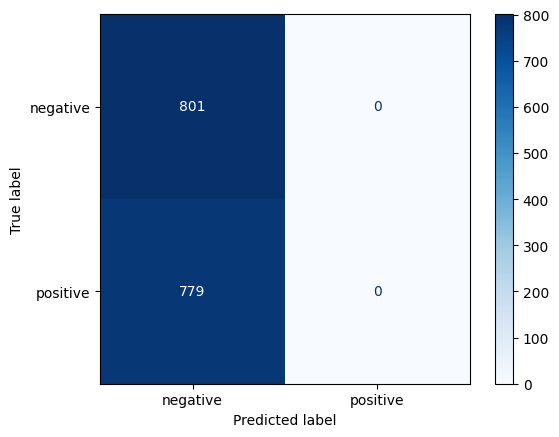

Classification Report (BERT + SVM):
              precision    recall  f1-score   support

    negative       0.75      0.76      0.76       801
    positive       0.75      0.75      0.75       779

    accuracy                           0.75      1580
   macro avg       0.75      0.75      0.75      1580
weighted avg       0.75      0.75      0.75      1580

Confusion Matrix (BERT + SVM):


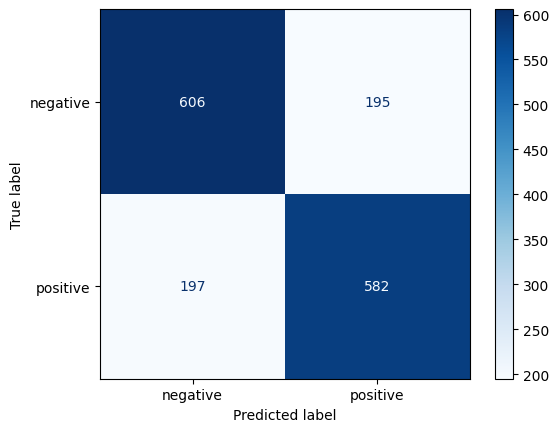

In [ ]:
# 评估模型
print("Classification Report (Word2Vec + SVM):")
print(classification_report(y_test, y_pred_svm_w2v,target_names=target_names))
conf_matrix_w2v_svm = confusion_matrix(y_test, y_pred_svm_w2v)
print("Confusion Matrix (Word2Vec + SVM):")
disp_w2v_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v_svm, display_labels=target_names)
disp_w2v_svm.plot(cmap=plt.cm.Blues)
plt.show()

# 评估模型
print("Classification Report (BERT + SVM):")
print(classification_report(y_test, y_pred_svm_bert,target_names=target_names))
conf_matrix_bert_svm = confusion_matrix(y_test, y_pred_svm_bert)
print("Confusion Matrix (BERT + SVM):")
disp_bert_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_svm, display_labels=target_names)
disp_bert_svm.plot(cmap=plt.cm.Blues)
plt.show()

### **使用XGBoost進行分類**

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 訓練XGBoost模型(Word2Vec)
clf_xgb_w2v = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
clf_xgb_w2v.fit(X_train_w2v, y_train)
y_pred_xgb_w2v = clf_xgb_w2v.predict(X_test_w2v)

In [ ]:
# @title BERT
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 訓練XGBoost模型 (BERT)
clf_xgb_bert = XGBClassifier()
clf_xgb_bert.fit(X_train_bert, y_train)
y_pred_xgb_bert = clf_xgb_bert.predict(X_test_bert)

Classification Report (Word2Vec + XGBoost ):
              precision    recall  f1-score   support

    negative       0.70      0.78      0.74       801
    positive       0.75      0.65      0.70       779

    accuracy                           0.72      1580
   macro avg       0.72      0.72      0.72      1580
weighted avg       0.72      0.72      0.72      1580

Confusion Matrix (Word2Vec + XGBoost ):


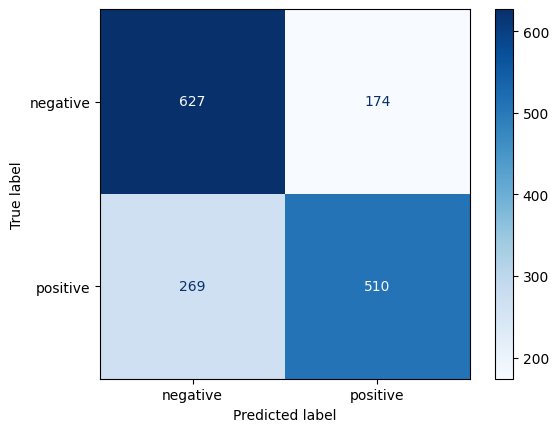

Classification Report (BERT + XGBoost):
              precision    recall  f1-score   support

    negative       0.74      0.77      0.75       801
    positive       0.75      0.72      0.73       779

    accuracy                           0.74      1580
   macro avg       0.74      0.74      0.74      1580
weighted avg       0.74      0.74      0.74      1580

Confusion Matrix (BERT + XGBoost ):


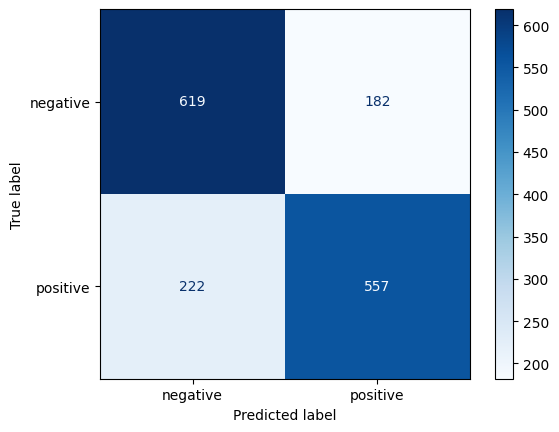

In [ ]:
#target_names = list(map(str, label_encoder.classes_))
# 評估XGBoost模型 (Word2Vec)
print("Classification Report (Word2Vec + XGBoost ):")
print(classification_report(y_test, y_pred_xgb_w2v, target_names=target_names))
conf_matrix_w2v_xgb = confusion_matrix(y_test, y_pred_xgb_w2v)
print("Confusion Matrix (Word2Vec + XGBoost ):")
disp_w2v_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v_xgb, display_labels=target_names)
disp_w2v_xgb.plot(cmap=plt.cm.Blues)
plt.show()

# 生成分類報告
print("Classification Report (BERT + XGBoost):")
print(classification_report(y_test, y_pred_xgb_bert, target_names=target_names))
conf_matrix_bert_xgb = confusion_matrix(y_test, y_pred_xgb_bert)
print("Confusion Matrix (BERT + XGBoost ):")
disp_bert_xgb = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_xgb, display_labels=target_names)
disp_bert_xgb.plot(cmap=plt.cm.Blues)
plt.show()

### **使用LSTM進行分類**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# 将标签进行编码
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 将标签转换为one-hot编码
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Word2Vec 向量需要调整形状，添加时间步伐维度
X_train_w2v_reshaped = np.reshape(X_train_w2v, (X_train_w2v.shape[0], 1, X_train_w2v.shape[1]))
X_test_w2v_reshaped = np.reshape(X_test_w2v, (X_test_w2v.shape[0], 1, X_test_w2v.shape[1]))

In [ ]:
# 定义LSTM模型
model_w2v = Sequential()
model_w2v.add(LSTM(128, input_shape=(1, 300), dropout=0.2, recurrent_dropout=0.2))
model_w2v.add(Dropout(0.2))
model_w2v.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# 编译模型
model_w2v.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model_w2v.fit(X_train_w2v_reshaped, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
158/158 [==============================] - 5s 10ms/step - loss: 0.6910 - accuracy: 0.5272 - val_loss: 0.6899 - val_accuracy: 0.5356
Epoch 2/10
158/158 [==============================] - 1s 9ms/step - loss: 0.6908 - accuracy: 0.5421 - val_loss: 0.6901 - val_accuracy: 0.5356
Epoch 3/10
158/158 [==============================] - 1s 9ms/step - loss: 0.6903 - accuracy: 0.5413 - val_loss: 0.6902 - val_accuracy: 0.5356
Epoch 4/10
158/158 [==============================] - 1s 9ms/step - loss: 0.6897 - accuracy: 0.5328 - val_loss: 0.6898 - val_accuracy: 0.5356
Epoch 5/10
158/158 [==============================] - 1s 8ms/step - loss: 0.6891 - accuracy: 0.5411 - val_loss: 0.6903 - val_accuracy: 0.5356
Epoch 6/10
158/158 [==============================] - 2s 10ms/step - loss: 0.6888 - accuracy: 0.5389 - val_loss: 0.6898 - val_accuracy: 0.5356
Epoch 7/10
158/158 [==============================] - 2s 15ms/step - loss: 0.6892 - accuracy: 0.5375 - val_loss: 0.6912 - val_accuracy: 0.5356
Epo

In [ ]:
# BERT 向量需要调整形状，添加时间步伐维度
X_train_bert_reshaped = np.reshape(X_train_bert, (X_train_bert.shape[0], 1, X_train_bert.shape[1]))
X_test_bert_reshaped = np.reshape(X_test_bert, (X_test_bert.shape[0], 1, X_test_bert.shape[1]))

# 定义LSTM模型
model_bert = Sequential()
model_bert.add(LSTM(128, input_shape=(1, 768), dropout=0.2, recurrent_dropout=0.2))
model_bert.add(Dropout(0.2))
model_bert.add(Dense(y_train_categorical.shape[1], activation='softmax'))

# 编译模型
model_bert.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model_bert.fit(X_train_bert_reshaped, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
158/158 [==============================] - 7s 20ms/step - loss: 0.5992 - accuracy: 0.6651 - val_loss: 0.5453 - val_accuracy: 0.7112
Epoch 2/10
158/158 [==============================] - 2s 12ms/step - loss: 0.5399 - accuracy: 0.7231 - val_loss: 0.5380 - val_accuracy: 0.7176
Epoch 3/10
158/158 [==============================] - 2s 13ms/step - loss: 0.5033 - accuracy: 0.7506 - val_loss: 0.5059 - val_accuracy: 0.7366
Epoch 4/10
158/158 [==============================] - 2s 12ms/step - loss: 0.4899 - accuracy: 0.7556 - val_loss: 0.5039 - val_accuracy: 0.7445
Epoch 5/10
158/158 [==============================] - 2s 13ms/step - loss: 0.4695 - accuracy: 0.7712 - val_loss: 0.5146 - val_accuracy: 0.7389
Epoch 6/10
158/158 [==============================] - 2s 16ms/step - loss: 0.4565 - accuracy: 0.7716 - val_loss: 0.4979 - val_accuracy: 0.7571
Epoch 7/10
158/158 [==============================] - 3s 20ms/step - loss: 0.4308 - accuracy: 0.7946 - val_loss: 0.4967 - val_accuracy: 0.7603

50/50 [==============================] - 0s 2ms/step
Classification Report (Word2Vec + LSTM):
              precision    recall  f1-score   support

    negative       0.51      1.00      0.67       801
    positive       0.00      0.00      0.00       779

    accuracy                           0.51      1580
   macro avg       0.25      0.50      0.34      1580
weighted avg       0.26      0.51      0.34      1580



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


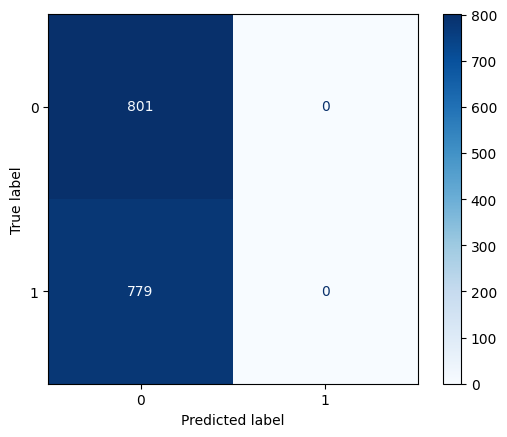

50/50 [==============================] - 0s 3ms/step
Classification Report (BERT + LSTM):
              precision    recall  f1-score   support

    negative       0.83      0.68      0.75       801
    positive       0.72      0.86      0.78       779

    accuracy                           0.77      1580
   macro avg       0.78      0.77      0.76      1580
weighted avg       0.78      0.77      0.76      1580



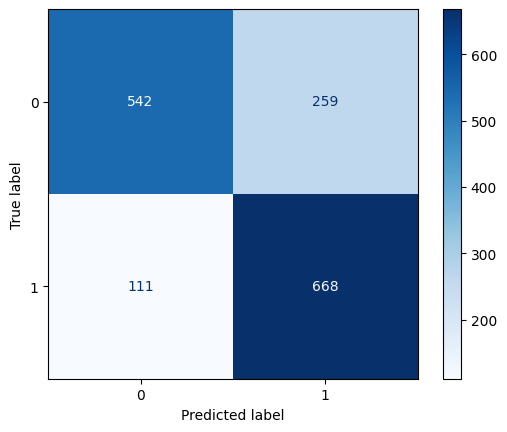

In [ ]:
# 预测
y_pred_w2v = model_w2v.predict(X_test_w2v_reshaped)
y_pred_classes_w2v = np.argmax(y_pred_w2v, axis=1)
y_test_classes_w2v = np.argmax(y_test_categorical, axis=1)

# 打印分类报告
print("Classification Report (Word2Vec + LSTM):")
print(classification_report(y_test_classes_w2v, y_pred_classes_w2v, target_names=target_names))

# 混淆矩阵
conf_matrix_w2v = confusion_matrix(y_test_classes_w2v, y_pred_classes_w2v)
disp_w2v = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v, display_labels=label_encoder.classes_)
disp_w2v.plot(cmap=plt.cm.Blues)
plt.show()

# 预测
y_pred_bert = model_bert.predict(X_test_bert_reshaped)
y_pred_classes_bert = np.argmax(y_pred_bert, axis=1)
y_test_classes_bert = np.argmax(y_test_categorical, axis=1)

# 打印分类报告
print("Classification Report (BERT + LSTM):")
print(classification_report(y_test_classes_bert, y_pred_classes_bert, target_names=target_names))

# 混淆矩阵
conf_matrix_bert = confusion_matrix(y_test_classes_bert, y_pred_classes_bert)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert, display_labels=label_encoder.classes_)
disp_bert.plot(cmap=plt.cm.Blues)
plt.show()

### **使用CNN**

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# 定義CNN模型
model_cnn_w2v = Sequential()
model_cnn_w2v.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(300, 1)))
model_cnn_w2v.add(MaxPooling1D(pool_size=2))
model_cnn_w2v.add(Flatten())
model_cnn_w2v.add(Dense(128, activation='relu'))
model_cnn_w2v.add(Dense(1, activation='sigmoid'))
# 編譯模型
model_cnn_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# 轉為三維輸入
X_train_w2v_cnn = np.expand_dims(X_train_w2v, axis=2)
X_test_w2v_cnn = np.expand_dims(X_test_w2v, axis=2)
# 訓練模型
model_cnn_w2v.fit(X_train_w2v_cnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_w2v_cnn, y_test))


Epoch 1/10
198/198 [==============================] - 24s 103ms/step - loss: 0.6926 - accuracy: 0.5333 - val_loss: 0.6942 - val_accuracy: 0.5070
Epoch 2/10
198/198 [==============================] - 11s 55ms/step - loss: 0.6907 - accuracy: 0.5400 - val_loss: 0.6950 - val_accuracy: 0.5070
Epoch 3/10
198/198 [==============================] - 10s 53ms/step - loss: 0.6901 - accuracy: 0.5400 - val_loss: 0.6971 - val_accuracy: 0.5070
Epoch 4/10
198/198 [==============================] - 12s 59ms/step - loss: 0.6902 - accuracy: 0.5400 - val_loss: 0.6957 - val_accuracy: 0.5070
Epoch 5/10
198/198 [==============================] - 17s 87ms/step - loss: 0.6901 - accuracy: 0.5400 - val_loss: 0.6942 - val_accuracy: 0.5070
Epoch 6/10
198/198 [==============================] - 19s 94ms/step - loss: 0.6901 - accuracy: 0.5400 - val_loss: 0.6951 - val_accuracy: 0.5070
Epoch 7/10
198/198 [==============================] - 18s 90ms/step - loss: 0.6897 - accuracy: 0.5400 - val_loss: 0.6972 - val_accuracy

In [ ]:
# 定义CNN模型
model_cnn_bert = Sequential()
model_cnn_bert.add(Conv1D(128, kernel_size=5, activation='relu', input_shape=(768, 1)))
model_cnn_bert.add(MaxPooling1D(pool_size=2))
model_cnn_bert.add(Flatten())
model_cnn_bert.add(Dense(128, activation='relu'))
model_cnn_bert.add(Dense(1, activation='sigmoid'))

# 编译模型
model_cnn_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# BERT特征需要调整为三维输入
X_train_bert_cnn = np.expand_dims(X_train_bert, axis=2)
X_test_bert_cnn = np.expand_dims(X_test_bert, axis=2)

# 训练模型
model_cnn_bert.fit(X_train_bert_cnn, y_train, epochs=15, batch_size=32, validation_data=(X_test_bert_cnn, y_test))

Epoch 1/15
198/198 [==============================] - 42s 203ms/step - loss: 0.6120 - accuracy: 0.6644 - val_loss: 0.5625 - val_accuracy: 0.7114
Epoch 2/15
198/198 [==============================] - 28s 141ms/step - loss: 0.5485 - accuracy: 0.7158 - val_loss: 0.5222 - val_accuracy: 0.7386
Epoch 3/15
198/198 [==============================] - 28s 140ms/step - loss: 0.5078 - accuracy: 0.7500 - val_loss: 0.5014 - val_accuracy: 0.7475
Epoch 4/15
198/198 [==============================] - 28s 144ms/step - loss: 0.4855 - accuracy: 0.7603 - val_loss: 0.4921 - val_accuracy: 0.7551
Epoch 5/15
198/198 [==============================] - 29s 146ms/step - loss: 0.4418 - accuracy: 0.7845 - val_loss: 0.4967 - val_accuracy: 0.7525
Epoch 6/15
198/198 [==============================] - 28s 140ms/step - loss: 0.4249 - accuracy: 0.8026 - val_loss: 0.6669 - val_accuracy: 0.6703
Epoch 7/15
198/198 [==============================] - 28s 142ms/step - loss: 0.4167 - accuracy: 0.8047 - val_loss: 0.5600 - val_ac

50/50 [==============================] - 0s 9ms/step
Classification Report (CNN + Word2Vec):
              precision    recall  f1-score   support

    negative       0.51      1.00      0.67       801
    positive       0.00      0.00      0.00       779

    accuracy                           0.51      1580
   macro avg       0.25      0.50      0.34      1580
weighted avg       0.26      0.51      0.34      1580



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


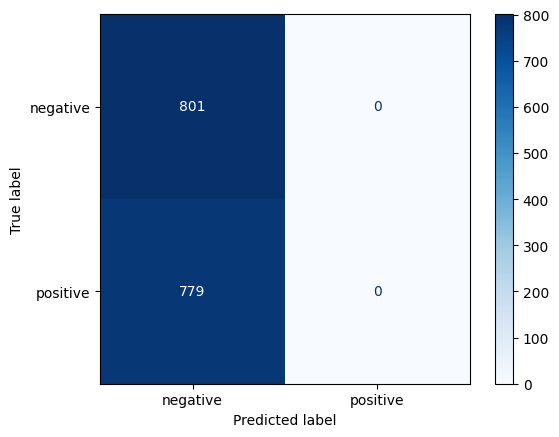

50/50 [==============================] - 1s 19ms/step
Classification Report (BERT + CNN):
              precision    recall  f1-score   support

    negative     0.8423    0.6667    0.7443       801
    positive     0.7178    0.8716    0.7872       779

    accuracy                         0.7677      1580
   macro avg     0.7800    0.7691    0.7657      1580
weighted avg     0.7809    0.7677    0.7654      1580



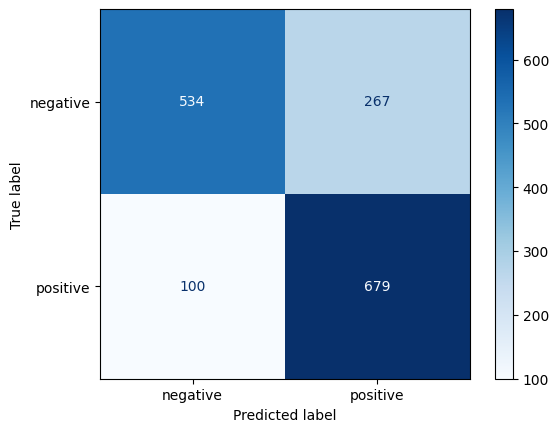

In [ ]:
# 使用测试集进行预测
y_pred = model_cnn_w2v.predict(X_test_w2v_cnn)
# 将概率值转换为二进制标签
y_pred_binary = (y_pred > 0.5).astype(int)
# 生成分类报告
print("Classification Report (CNN + Word2Vec):")
print(classification_report(y_test, y_pred_binary,target_names=target_names))
# 生成混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred_binary)
disp_w2v_cnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp_w2v_cnn.plot(cmap=plt.cm.Blues)
plt.show()

# 生成預測
y_pred_proba = model_cnn_bert.predict(X_test_bert_cnn)
y_pred = (y_pred_proba > 0.5).astype(int)

# 分類報告
print("Classification Report (BERT + CNN):")
print(classification_report(y_test, y_pred, digits=4,target_names=target_names))

# 混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
disp_bert_cnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
disp_bert_cnn.plot(cmap=plt.cm.Blues)
plt.show()

### **使用RNN**

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Reshape，使其適應 RNN 輸入要求
X_train_w2v_reshaped = np.expand_dims(X_train_w2v, axis=1)  # shape = (samples, timesteps, features)
X_test_w2v_reshaped = np.expand_dims(X_test_w2v, axis=1)

# 標籤編碼
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 獨熱編碼
y_train_categorical = to_categorical(y_train_encoded, num_classes=2)
y_test_categorical = to_categorical(y_test_encoded, num_classes=2)

target_names = ['negative', 'positive']

# 定義RNN模型
model_w2v_rnn = Sequential()
model_w2v_rnn.add(SimpleRNN(128, input_shape=(1, 300), dropout=0.2, recurrent_dropout=0.2))
model_w2v_rnn.add(Dropout(0.2))
model_w2v_rnn.add(Dense(2, activation='softmax'))
# 編譯模型
model_w2v_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# 訓練模型
model_w2v_rnn.fit(X_train_w2v_reshaped, y_train_categorical, epochs=30, batch_size=32, validation_split=0.2)

# 在测试集上预测
y_pred_rnn = model_w2v_rnn.predict(X_test_w2v_reshaped)
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)

Epoch 1/30
158/158 [==============================] - 2s 6ms/step - loss: 0.7100 - accuracy: 0.5211 - val_loss: 0.6892 - val_accuracy: 0.5356
Epoch 2/30
158/158 [==============================] - 1s 6ms/step - loss: 0.7103 - accuracy: 0.5124 - val_loss: 0.6879 - val_accuracy: 0.5348
Epoch 3/30
158/158 [==============================] - 1s 6ms/step - loss: 0.6995 - accuracy: 0.5231 - val_loss: 0.7147 - val_accuracy: 0.4810
Epoch 4/30
158/158 [==============================] - 1s 6ms/step - loss: 0.6952 - accuracy: 0.5330 - val_loss: 0.6894 - val_accuracy: 0.5071
Epoch 5/30
158/158 [==============================] - 1s 6ms/step - loss: 0.6977 - accuracy: 0.5256 - val_loss: 0.7055 - val_accuracy: 0.4826
Epoch 6/30
158/158 [==============================] - 1s 6ms/step - loss: 0.6918 - accuracy: 0.5300 - val_loss: 0.6892 - val_accuracy: 0.5356
Epoch 7/30
158/158 [==============================] - 1s 6ms/step - loss: 0.6910 - accuracy: 0.5306 - val_loss: 0.6879 - val_accuracy: 0.5356
Epoch 

In [ ]:
# Reshape 数据，使其适应 RNN 输入要求
X_train_bert_reshaped = np.expand_dims(X_train_bert, axis=1)  # shape = (samples, timesteps, features)
X_test_bert_reshaped = np.expand_dims(X_test_bert, axis=1)

# 标签编码
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 独热编码标签
y_train_categorical = to_categorical(y_train_encoded, num_classes=2)
y_test_categorical = to_categorical(y_test_encoded, num_classes=2)

# 定义 RNN 模型
model_bert_rnn = Sequential()
model_bert_rnn.add(SimpleRNN(128, input_shape=(1, 768), dropout=0.2, recurrent_dropout=0.2))
model_bert_rnn.add(Dropout(0.2))
model_bert_rnn.add(Dense(2, activation='softmax'))

# 编译模型
model_bert_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model_bert_rnn.fit(X_train_bert_reshaped, y_train_categorical, epochs=30, batch_size=32, validation_split=0.2)

# 在测试集上预测
y_pred_rnn_bert = model_bert_rnn.predict(X_test_bert_reshaped)
y_pred_rnn_bert_classes = np.argmax(y_pred_rnn_bert, axis=1)

Epoch 1/30
158/158 [==============================] - 3s 8ms/step - loss: 0.6340 - accuracy: 0.6523 - val_loss: 0.5380 - val_accuracy: 0.7263
Epoch 2/30
158/158 [==============================] - 1s 6ms/step - loss: 0.5680 - accuracy: 0.7029 - val_loss: 0.5218 - val_accuracy: 0.7247
Epoch 3/30
158/158 [==============================] - 1s 6ms/step - loss: 0.5541 - accuracy: 0.7152 - val_loss: 0.5311 - val_accuracy: 0.7089
Epoch 4/30
158/158 [==============================] - 1s 5ms/step - loss: 0.5333 - accuracy: 0.7281 - val_loss: 0.5273 - val_accuracy: 0.7199
Epoch 5/30
158/158 [==============================] - 1s 6ms/step - loss: 0.5179 - accuracy: 0.7406 - val_loss: 0.5111 - val_accuracy: 0.7468
Epoch 6/30
158/158 [==============================] - 2s 10ms/step - loss: 0.5207 - accuracy: 0.7396 - val_loss: 0.5102 - val_accuracy: 0.7366
Epoch 7/30
158/158 [==============================] - 2s 11ms/step - loss: 0.5056 - accuracy: 0.7518 - val_loss: 0.5110 - val_accuracy: 0.7326
Epoc

Classification Report (Word2Vec + RNN):
              precision    recall  f1-score   support

    negative       0.51      1.00      0.67       801
    positive       0.50      0.00      0.00       779

    accuracy                           0.51      1580
   macro avg       0.50      0.50      0.34      1580
weighted avg       0.50      0.51      0.34      1580

Confusion Matrix (Word2Vec + RNN):


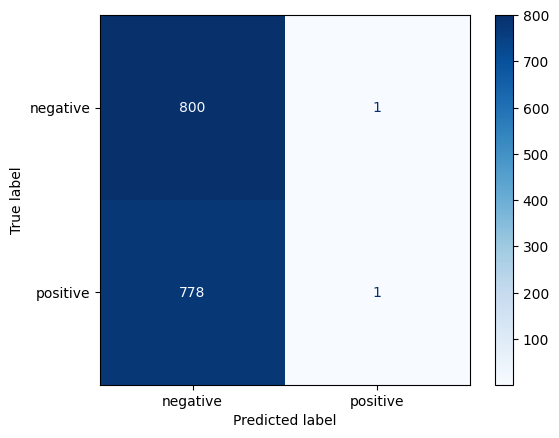

Classification Report (BERT + RNN):
              precision    recall  f1-score   support

    negative       0.79      0.77      0.78       801
    positive       0.77      0.79      0.78       779

    accuracy                           0.78      1580
   macro avg       0.78      0.78      0.78      1580
weighted avg       0.78      0.78      0.78      1580

Confusion Matrix (BERT + RNN):


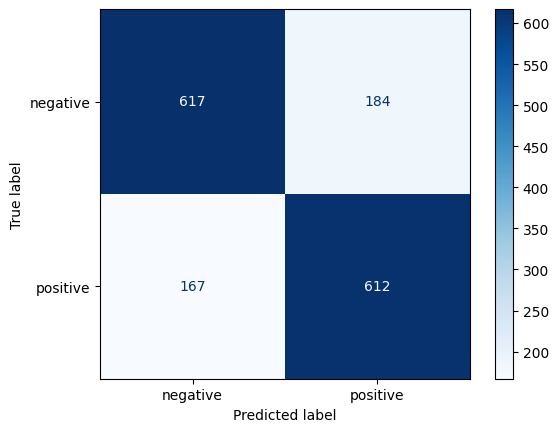

In [ ]:
# 打印分类报告和混淆矩阵
print("Classification Report (Word2Vec + RNN):")
print(classification_report(y_test_encoded, y_pred_rnn_classes, target_names=target_names))
print("Confusion Matrix (Word2Vec + RNN):")
conf_matrix_w2v_rnn = confusion_matrix(y_test_encoded, y_pred_rnn_classes)
disp_w2v_rnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v_rnn, display_labels=target_names)
disp_w2v_rnn.plot(cmap=plt.cm.Blues)
plt.show()

# 打印分类报告和混淆矩阵
print("Classification Report (BERT + RNN):")
print(classification_report(y_test_encoded, y_pred_rnn_bert_classes, target_names=target_names))
print("Confusion Matrix (BERT + RNN):")
conf_matrix_bert_rnn = confusion_matrix(y_test_encoded, y_pred_rnn_bert_classes)
disp_bert_rnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_rnn, display_labels=target_names)
disp_bert_rnn.plot(cmap=plt.cm.Blues)
plt.show()

### **使用DNN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# 创建MLP模型 (Word2Vec)
model_mlp_w2v = Sequential()
model_mlp_w2v.add(Dense(512, activation='relu', input_dim=300))
model_mlp_w2v.add(Dropout(0.5))
model_mlp_w2v.add(Dense(1, activation='sigmoid'))  # 输出层改为1，适用于二分类

# 编译模型
model_mlp_w2v.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 定义早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 训练模型
model_mlp_w2v.fit(X_train_w2v, y_train, epochs=30, batch_size=32, validation_data=(X_test_w2v, y_test), callbacks=[early_stopping])

# 在测试集上做出预测
y_pred_w2v_dnn = model_mlp_w2v.predict(X_test_w2v)
y_pred_w2v_dnn = (y_pred_w2v_dnn > 0.5).astype(int)

Epoch 1/30
198/198 [==============================] - 5s 10ms/step - loss: 0.7014 - accuracy: 0.5137 - val_loss: 0.7016 - val_accuracy: 0.5070
Epoch 2/30
198/198 [==============================] - 2s 9ms/step - loss: 0.6936 - accuracy: 0.5270 - val_loss: 0.6961 - val_accuracy: 0.5070
Epoch 3/30
198/198 [==============================] - 2s 8ms/step - loss: 0.6901 - accuracy: 0.5373 - val_loss: 0.6955 - val_accuracy: 0.5070
Epoch 4/30
198/198 [==============================] - 1s 8ms/step - loss: 0.6904 - accuracy: 0.5401 - val_loss: 0.6995 - val_accuracy: 0.5070
Epoch 5/30
198/198 [==============================] - 2s 9ms/step - loss: 0.6902 - accuracy: 0.5385 - val_loss: 0.6962 - val_accuracy: 0.5070
Epoch 6/30
50/50 [==============================] - 0s 2ms/step


In [ ]:
# 创建MLP模型 (BERT)
model_mlp_bert = Sequential()
model_mlp_bert.add(Dense(512, activation='relu', input_dim=768))
model_mlp_bert.add(Dropout(0.5))
model_mlp_bert.add(Dense(1, activation='sigmoid'))  # 输出层改为1，适用于二分类

# 编译模型
model_mlp_bert.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 定义早停策略
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 训练模型
model_mlp_bert.fit(X_train_bert, y_train, epochs=10, batch_size=32, validation_data=(X_test_bert, y_test), callbacks=[early_stopping])

# 在测试集上做出预测
y_pred_bert_dnn = model_mlp_bert.predict(X_test_bert)
y_pred_bert_dnn = (y_pred_bert_dnn > 0.5).astype(int)

Epoch 1/10
198/198 [==============================] - 5s 21ms/step - loss: 0.6033 - accuracy: 0.6669 - val_loss: 0.5290 - val_accuracy: 0.7354
Epoch 2/10
198/198 [==============================] - 4s 18ms/step - loss: 0.5294 - accuracy: 0.7341 - val_loss: 0.5061 - val_accuracy: 0.7513
Epoch 3/10
198/198 [==============================] - 3s 13ms/step - loss: 0.5103 - accuracy: 0.7390 - val_loss: 0.5114 - val_accuracy: 0.7525
Epoch 4/10
198/198 [==============================] - 2s 12ms/step - loss: 0.4851 - accuracy: 0.7603 - val_loss: 0.4911 - val_accuracy: 0.7532
Epoch 5/10
198/198 [==============================] - 2s 11ms/step - loss: 0.4708 - accuracy: 0.7690 - val_loss: 0.4825 - val_accuracy: 0.7671
Epoch 6/10
198/198 [==============================] - 2s 10ms/step - loss: 0.4618 - accuracy: 0.7741 - val_loss: 0.4791 - val_accuracy: 0.7595
Epoch 7/10
198/198 [==============================] - 3s 14ms/step - loss: 0.4374 - accuracy: 0.7891 - val_loss: 0.4859 - val_accuracy: 0.7595

Classification Report (Word2Vec + DNN):
              precision    recall  f1-score   support

    negative       0.51      1.00      0.67       801
    positive       0.00      0.00      0.00       779

    accuracy                           0.51      1580
   macro avg       0.25      0.50      0.34      1580
weighted avg       0.26      0.51      0.34      1580

Confusion Matrix (Word2Vec + DNN):


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


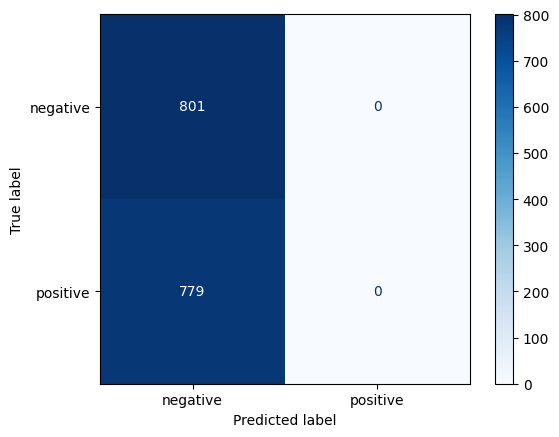

Classification Report (BERT + DNN):
              precision    recall  f1-score   support

    negative       0.76      0.80      0.78       801
    positive       0.78      0.74      0.76       779

    accuracy                           0.77      1580
   macro avg       0.77      0.77      0.77      1580
weighted avg       0.77      0.77      0.77      1580

Confusion Matrix (BERT + DNN):


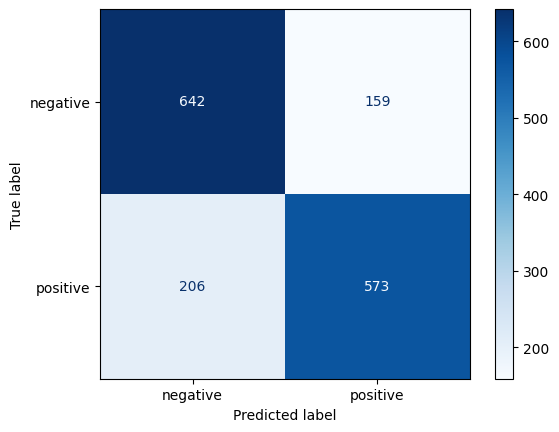

In [ ]:
target_names = ['negative', 'positive']
# 评估模型
print("Classification Report (Word2Vec + DNN):")
print(classification_report(y_test, y_pred_w2v_dnn,target_names=target_names))
conf_matrix_w2v_dnn = confusion_matrix(y_test, y_pred_w2v_dnn)
print("Confusion Matrix (Word2Vec + DNN):")
disp_bert_dnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_w2v_dnn, display_labels=target_names)
disp_bert_dnn.plot(cmap=plt.cm.Blues)
plt.show()

# 评估模型
print("Classification Report (BERT + DNN):")
print(classification_report(y_test, y_pred_bert_dnn,target_names=target_names))
conf_matrix_bert_dnn = confusion_matrix(y_test, y_pred_bert_dnn)
print("Confusion Matrix (BERT + DNN):")
disp_bert_dnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_bert_dnn, display_labels=target_names)
disp_bert_dnn.plot(cmap=plt.cm.Blues)
plt.show()